In [1]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [2]:
! pip uninstall tensorflow==2.17.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.1


In [3]:
!pip install tensorflow==2.8.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 42.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At


# Model 1: Multivariate-3-RNN



In [ ]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
print(tf.__version__)


2.8.4


In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'FPT.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)

In [ ]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-12-14,17021.1,17021.1,17021.1,17021.1,4020000.0
2006-12-15,17872.1,17872.1,17872.1,17872.1,3800000.0
2006-12-18,18763.7,18763.7,18763.7,18763.7,3090000.0
2006-12-19,19695.8,19695.8,19695.8,19695.8,1970000.0
2006-12-20,20668.4,20668.4,20668.4,20668.4,3150000.0


In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


<Axes: >

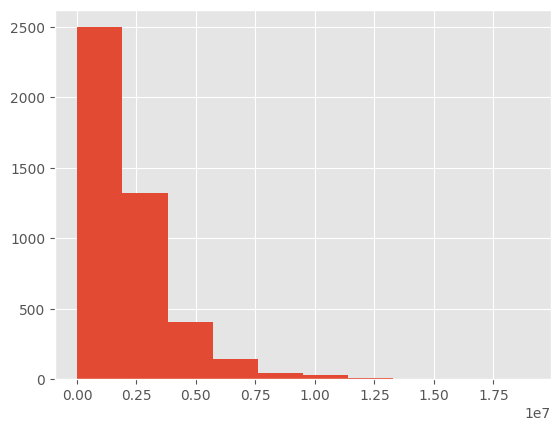

In [ ]:
# Distribution of Various Features
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

## Train model

In [ ]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_2(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Evaluate Model

In [ ]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart

In [ ]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## Model building

In [ ]:
# Extracting the series
series = df[['Close', 'High', 'Low']] # Picking the multivariate series
print(series.shape)
series

(4451, 3)


,Close,High,Low
Date,,,
2006-12-14,17021.1,17021.1,17021.1
2006-12-15,17872.1,17872.1,17872.1
2006-12-18,18763.7,18763.7,18763.7
2006-12-19,19695.8,19695.8,19695.8
2006-12-20,20668.4,20668.4,20668.4
...,...,...,...
2024-10-21,135500.0,137700.0,135500.0
2024-10-22,133100.0,135700.0,133000.0
2024-10-23,134200.0,134800.0,132600.0


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3784]         # Next 463 rows for validation
test_data = series.iloc[3784:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 3) (667, 3) (667, 3)


,Close,High,Low
Date,,,
2006-12-14,17021.1,17021.1,17021.1
2006-12-15,17872.1,17872.1,17872.1
2006-12-18,18763.7,18763.7,18763.7
2006-12-19,19695.8,19695.8,19695.8
2006-12-20,20668.4,20668.4,20668.4


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 3) (667, 3) (667, 3)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 149: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 149: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 87: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 87: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 124: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 124: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 89: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 89: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 139: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 139: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.11860833870043841
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.625878  0.791124   
1          30  [40, 35]  0.0010          32         250  0.625878  0.791124   
2          30  [40, 35]  0.0010          64         200  0.185562  0.430769   
3          30  [40, 35]  0.0010          64         250  0.185562  0.430769   
4          30  [40, 35]  0.0001          32         200  0.728845  0.853724   
5          30  [40, 35]  0.0001          32         250  0.728845  0.853724   
6          30  [40, 35]  0.0001          64         200  0.064021  0.253025   
7          30  [40, 35]  0.0001          64         250  0.064021  0.253025   
8          40  [40, 35]  0.0010          32         200  0.589774  0.767967   
9          40  [40, 35]  0.0010          32         250  0.589774  0.76

In [ ]:
timesteps =50
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


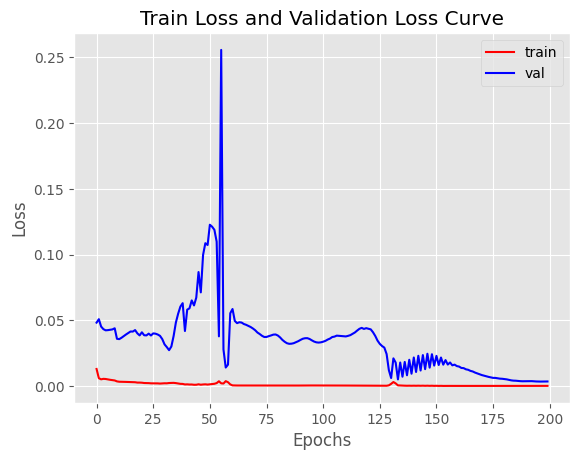

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.014067938009277916
RMSE = 0.11860833870043841
MAPE = 0.02361231523890486
R-Squared Score = 0.9863938797459536


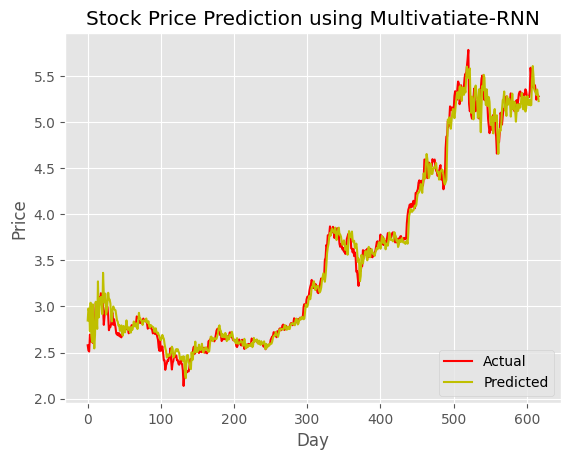

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 2: Multivariate-3-GRU


In [ ]:
import sys
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

##Data preprocessing

In [ ]:
url = 'FPT.csv'
df = pd.read_csv(url, parse_dates = True, index_col = 0)

In [ ]:
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


##Train Model


In [ ]:
def fit_model_3(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Evaluate Model


In [ ]:
def evaluate_model_3(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart


In [ ]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building


In [ ]:
series = df[['Close','High','Low']] # Picking the features
print(series.shape)

(4451, 3)


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3784]         # Next 463 rows for validation
test_data = series.iloc[3784:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 3) (667, 3) (667, 3)


,Close,High,Low
Date,,,
2006-12-14,17021.1,17021.1,17021.1
2006-12-15,17872.1,17872.1,17872.1
2006-12-18,18763.7,18763.7,18763.7
2006-12-19,19695.8,19695.8,19695.8
2006-12-20,20668.4,20668.4,20668.4


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 3) (667, 3) (667, 3)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


In [ ]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


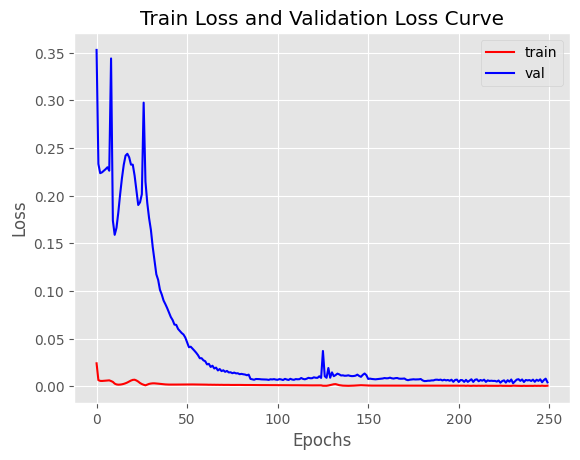

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.028201632906140323
RMSE = 0.16793341807436757
MAPE = 0.03734634480791883
R-Squared Score = 0.97272416125033


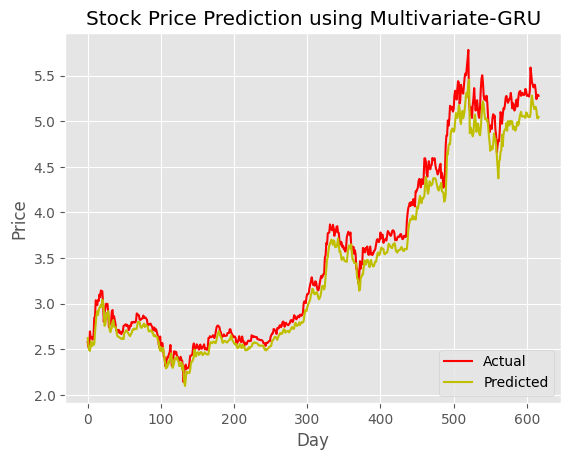

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model

# Model 3: Multivariate-3-LSTM


In [4]:
import sys
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [5]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [6]:
# Loading the dataset
url = 'FPT.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [7]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


In [8]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


## Train Model


In [9]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [10]:
def evaluate_model_4(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [23]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200],  # Số epoch
}

In [24]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


##Plot chart

In [25]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [26]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building

In [27]:
series = df[['Close','High','Low']] # Picking the features
print(series.shape)

(4451, 3)


In [28]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3784]         # Next 463 rows for validation
test_data = series.iloc[3784:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 3) (667, 3) (667, 3)


,Close,High,Low
Date,,,
2006-12-14,17021.1,17021.1,17021.1
2006-12-15,17872.1,17872.1,17872.1
2006-12-18,18763.7,18763.7,18763.7
2006-12-19,19695.8,19695.8,19695.8
2006-12-20,20668.4,20668.4,20668.4


In [29]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 3) (667, 3) (667, 3)


In [30]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 94: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 107: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 94: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 93: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 104: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 104: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 92: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 3.1208148610198747
    timesteps        hl      lr  batch_size  num_epochs           MSE  \
0          30  [40, 35]  0.0010          32         200  1.285938e+01   
1          30  [40, 35]  0.0010          64         200  9.739485e+00   
2          30  [40, 35]  0.0001          32         200  1.592142e+03   
3          30  [40, 35]  0.0001          64         200  4.155519e+01   
4          40  [40, 35]  0.0010          32         200  1.227080e+01   
5          40  [40, 35]  0.0010          64         200  2.270368e+01   
6          40  [40, 35]  0.0001          32         200  6.150835e+05   
7          40  [40, 35]  0.0001          64         200  6.370969e+02   
8          50  [40, 35]  0.0010          32         200  9.868622e+01   
9          50  [40, 35]  0.0010          64         200  2.302200e+01   
10         50  [40, 35]  0.0001    

In [31]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping


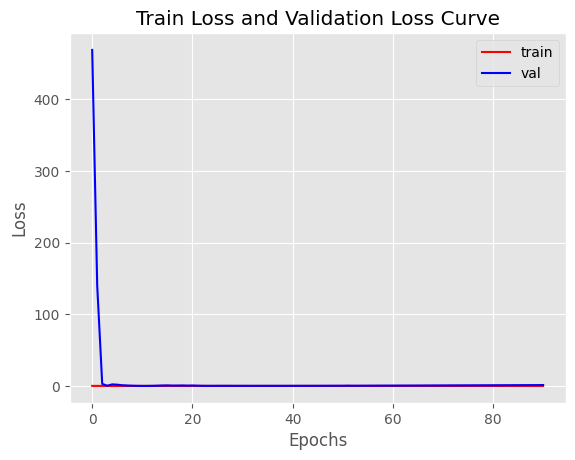

In [32]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 9.739485396762499
RMSE = 3.1208148610198747
MAPE = 0.6644300175807182
R-Squared Score = -8.651290159156604


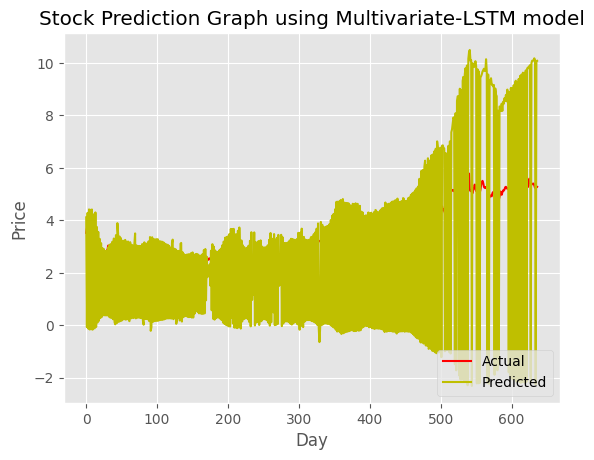

In [33]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [22]:
# Save a model
#model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model